In [1]:
%%capture
%run 02_FeatEng.ipynb

In [2]:
from fbprophet import Prophet
from  sklearn.metrics import mean_squared_error  as skl_mse

Importing plotly failed. Interactive plots will not work.


In [3]:
import mle.tsa as mle_tsa

In [4]:
OUTPATH = 'data/out/'
OUTFILE = 'cons_gna95_test_fbprophet.xlsx'

# Split Data

In [5]:
endog_GNA95_train = data_train.loc['2010':, ['cons_GNA95']].copy()
endog_GNA95_train['y'] = np.log(endog_GNA95_train['cons_GNA95']/1e3)
endog_GNA95_train['ds'] = endog_GNA95_train.index.strftime("%Y-%m-%d")

In [6]:
endog_GNA95_test = data_test[['cons_GNA95']].copy()
endog_GNA95_test['y'] = np.log(endog_GNA95_test['cons_GNA95']/1e3)
endog_GNA95_test['ds'] = endog_GNA95_test.index.strftime("%Y-%m-%d")

# Model Building

In [7]:
mod_prophet = Prophet()
res_prophet = mod_prophet.fit(df=endog_GNA95_train[['ds', 'y']])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [8]:
future = mod_prophet.make_future_dataframe(periods=12, freq='M')
future.tail()

,ds
117,2019-09-30
118,2019-10-31
119,2019-11-30
120,2019-12-31
121,2020-01-31


In [9]:
forecast = res_prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
117,2019-09-30,6.053451,6.026492,6.081810
118,2019-10-31,5.924281,5.894081,5.953876
119,2019-11-30,6.055847,6.028195,6.084365
120,2019-12-31,5.908855,5.877591,5.940742
121,2020-01-31,5.954238,5.923479,5.986179


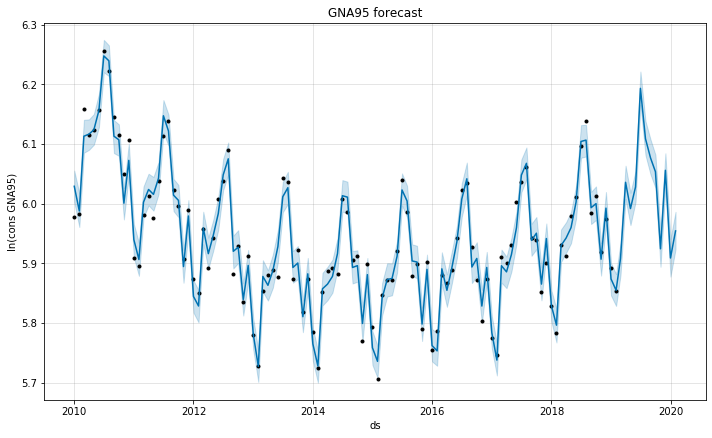

In [10]:
fig1 = res_prophet.plot(forecast)
plt.title('GNA95 forecast')
plt.ylabel(r'ln(cons GNA95)')
plt.show()

In [11]:
mstep_forecast_test = forecast[-12:]
mstep_forecast_test.index = pd.to_datetime(mstep_forecast_test['ds'])
mstep_forecast_test = mstep_forecast_test.resample('MS').first()
mstep_forecast_test['p_cons_GNA95'] = np.exp(mstep_forecast_test['yhat'])*1e3
mstep_forecast_test['upper cons_GNA95'] = np.exp(mstep_forecast_test['yhat_upper'])*1e3
mstep_forecast_test['lower cons_GNA95'] = np.exp(mstep_forecast_test['yhat_lower'])*1e3
mstep_forecast_test.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,p_cons_GNA95,upper cons_GNA95,lower cons_GNA95
ds,,,,,,,,,,,,,,,,,,,
2019-09-01,2019-09-30,6.032517,6.026492,6.081810,6.026764,6.040607,0.020934,0.020934,0.020934,0.020934,0.020934,0.020934,0.0,0.0,0.0,6.053451,425579.014180,437820.987407,414259.053165
2019-10-01,2019-10-31,6.036589,5.894081,5.953876,6.029634,6.046391,-0.112307,-0.112307,-0.112307,-0.112307,-0.112307,-0.112307,0.0,0.0,0.0,5.924281,374009.591341,385243.739681,362883.370513
2019-11-01,2019-11-30,6.040530,6.028195,6.084365,6.032266,6.052078,0.015318,0.015318,0.015318,0.015318,0.015318,0.015318,0.0,0.0,0.0,6.055847,426600.289108,438940.780508,414965.527786
2019-12-01,2019-12-31,6.044602,5.877591,5.940742,6.034694,6.057862,-0.135747,-0.135747,-0.135747,-0.135747,-0.135747,-0.135747,0.0,0.0,0.0,5.908855,368284.264701,380217.121838,356948.164620
2020-01-01,2020-01-31,6.048674,5.923479,5.986179,6.037021,6.063658,-0.094436,-0.094436,-0.094436,-0.094436,-0.094436,-0.094436,0.0,0.0,0.0,5.954238,385383.175448,397891.233016,373709.424788


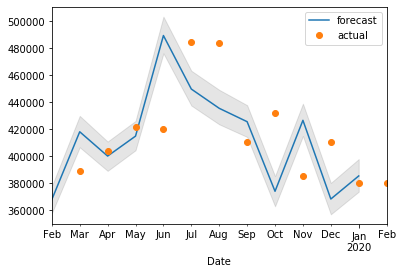

In [12]:
fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(111)

mstep_forecast_test.plot(y='p_cons_GNA95', label='forecast', ax=ax)
ax.fill_between(x=mstep_forecast_test.index, y1=mstep_forecast_test['upper cons_GNA95'], y2=mstep_forecast_test['lower cons_GNA95'],  color='k', alpha=0.1)
endog_GNA95_test['cons_GNA95'].plot(ax=ax, y='cons_GNA95', style='o', label='actual')
plt.legend()
plt.show()

In [13]:
mle_tsa.compute_ape(endog_GNA95_test['cons_GNA95'], mstep_forecast_test['p_cons_GNA95']).mean()

0.07554775382004465

# Forecast

In [14]:
forecast_mods, forecast_test = mle_tsa.prophet_endog_forecast(train_endog=endog_GNA95_train, test_endog=endog_GNA95_test)

C:\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [15]:
p_gna95_test = endog_GNA95_test[['cons_GNA95']].copy()
p_gna95_test.index = forecast_test['ds']
p_gna95_test.index.name = 'Date'
p_gna95_test['p_cons_GNA95'] = np.exp(forecast_test['yhat'].values)*1e3
p_gna95_test['upper p_cons_GNA95'] = np.exp(forecast_test['yhat_upper'].values)*1e3
p_gna95_test['lower p_cons_GNA95'] = np.exp(forecast_test['yhat_lower'].values)*1e3

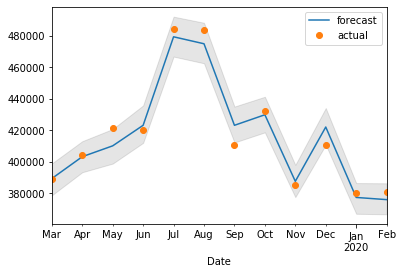

In [16]:
fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(111)

p_gna95_test.plot(y='p_cons_GNA95', label='forecast', ax=ax)
ax.fill_between(x=p_gna95_test.index, y1=p_gna95_test['upper p_cons_GNA95'], y2=p_gna95_test['lower p_cons_GNA95'],  color='k', alpha=0.1)
p_gna95_test['cons_GNA95'].plot(ax=ax, y='cons_GNA95', style='o', label='actual')
plt.legend()
plt.show()

# Model Assessment

In [17]:
select_cols = ['model', 'cons_GNA95', 'p_cons_GNA95', 'lower p_cons_GNA95', 'upper p_cons_GNA95']

p_gna95_test['model'] = 'fbprophet'
p_gna95_test.index = p_gna95_test.index.date
p_gna95_test[select_cols].to_excel(OUTPATH + OUTFILE, index_label='Date')

In [18]:
skl_mse(np.log(endog_GNA95_test['cons_GNA95']/1e3), forecast_test['yhat'])**0.5

0.016466978761114328

In [19]:
mle_tsa.compute_ape(p_gna95_test['cons_GNA95'], p_gna95_test['p_cons_GNA95']).mean()

0.013019854121495417

In [20]:
p_gna95_test.index 

Index([2019-03-01, 2019-04-01, 2019-05-01, 2019-06-01, 2019-07-01, 2019-08-01,
       2019-09-01, 2019-10-01, 2019-11-01, 2019-12-01, 2020-01-01, 2020-02-01],
      dtype='object')